# __Codename: Plutus IO__

##### __Functional TODOs__:

1. Improve lifetime visualisation:
2. Put Party Events in a config too
3. Create generic "adapter" functions to adapt individual configs for certain behaviour
4. Add a configmap of configs (for easier switching between scenarios)
2. Add land
3. Add "tax account"
4. Add concept of a family

In [1]:
# libs
import sys, logging, json
sys.path.append("/home/rado/Projects/wealthManagement/plutus/")

from context.instruments import CurrentAccount, Mortgage
from context.assets import RealEstate
from context.agreements import RentalAgreement, UtilitiesAgreement, EmployeeContract
from context.party import Party, Portfolio, setup_portfolio
from context.behaviour import transfer
from context.market import extrapolate_index, setup_market

# delete log
import os
if os.path.exists("plutus.log"): os.remove("plutus.log")

## Setup

In [2]:
# (1) High-level configuration
with open('_config_run.json') as f: config = json.load(f)
    
# loggers
logger = logging.getLogger('plutusLogger')
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s :: %(name)s | %(levelname)s | %(message)s')

fileHandler = logging.FileHandler(config['logPath'])
fileHandler.setFormatter(formatter)
logger.addHandler(fileHandler)
    
# (2) Market
with open('_config_market.json') as f: market_config = json.load(f)
indices = setup_market(market_config, config, logger)

# (3) Portfolio
with open('_config_portfolio.json') as f: portfolio_config = json.load(f)
portfolio = setup_portfolio(portfolio_config, indices, logger)

In [3]:
portfolio

{'rado_employee_contract': <context.agreements.EmployeeContract at 0x7f1be073b310>,
 'rado_current_account': <context.instruments.CurrentAccount at 0x7f1b978e80d0>,
 'rado_saving_account': <context.instruments.CurrentAccount at 0x7f1b978e8130>,
 'rado_inherited_flat': <context.assets.RealEstate at 0x7f1b978e8160>,
 'rado_mortgage_flat': <context.assets.RealEstate at 0x7f1b978e8220>,
 'rado_rent_from_inherited_flat': <context.agreements.RentalAgreement at 0x7f1b978e8190>,
 'rado_O2_share': <context.instruments.Share at 0x7f1b978e81c0>,
 'rado_mortgage': <context.instruments.Mortgage at 0x7f1b978e81f0>}

In [4]:
# configs for complicated Events:

# (1) employee contract
# portfolio_config['employee_contracts'][0]['events'] = {'modify': [{'step':2, 'value':0}, {'step':4, 'value': 0}], 'bonus':[{'step':9, 'value':0}]}

# (2) mortgage
# mortgage_flat_events = {'cost': [{'step':4, 'value':10000}, {'step': 5, 'value': 270000}], 'income':{}}

# dump to update versions:
# with open('_config_portfolio.json', 'w') as f: json.dump(portfolio_config, f, indent=4)

In [5]:
# party-level events
# rado_events = {'sell': [{'step':6, 'id':'rado_mortgage_flat'}]
#              , 'buy': [{'step':8, 'id':'rado_flat3', 'type':'RealEstate', 'current_market_value':3e6, 'property_tax':2000, 'house_community_costs':6000, 'real_estate_index':re_index}]
#              , 'transfer': [{'step':10, 'from':'rado_current_account', 'to':'rado_saving_account','amount':1e6}]}

rado_events = {'transfer': transfer(amount=25000, a='rado_current_account', b='rado_saving_account', n_years=config['n_years'], frequency=1)}

#### [5] Parties

In [6]:
rado = Party(id='Rado'
             , logger=logger 
             , initial_free_cash=0
             , initial_portfolio=Portfolio(logger, elements = portfolio)
             , monthly_expenditures=50000
             , discount_rate=0.015
             , events=rado_events)

## __Simulation__

In [7]:
logger.info('')
logger.info('============================================')
logger.info('============== SIMULATION  =================')
logger.info('============================================')
logger.info('')

In [8]:
rado.live(config['n_years']*12+1)

In [9]:
# plots
from core.plots import PartyPlotter

plt = PartyPlotter(rado)

### Plots

In [10]:
#plt.plot_position_evolution()

[1500000.         1492868.79914397 1485725.48501525 1478570.03703787
 1471402.43460092 1464222.65705845 1457030.68372948 1449826.49389786
 1442610.06681228 1435381.38168618 1428140.41769767 1420887.15398951
 1413621.56966902 1406343.64380804 1399053.35544286 1391750.68357415
 1384435.60716693 1377108.10515047 1369768.15641825 1362415.73982792
 1355050.83420118 1347673.41832379 1340283.47094546 1332880.9707798
 1325465.89650427 1318038.2267601  1310597.94015227 1303145.01524937
 1295679.43058362 1288201.16465077 1280710.19591004 1273206.50278404
 1265690.06365877 1258160.85688347 1250618.86077064 1243064.05359591
 1235496.41359804 1227915.91897881 1220322.54790296 1212716.27849816
 1205097.08885491 1197464.95702653 1189819.861029   1182161.77884102
 1174490.68840384 1166806.56762126 1159109.39435954 1151399.14644735
 1143675.8016757  1135939.33779785 1128189.73252931 1120426.96354771
 1112651.00849277 1104861.84496624 1097059.45053179 1089243.80271502
 1081414.87900332 1073572.65684587 

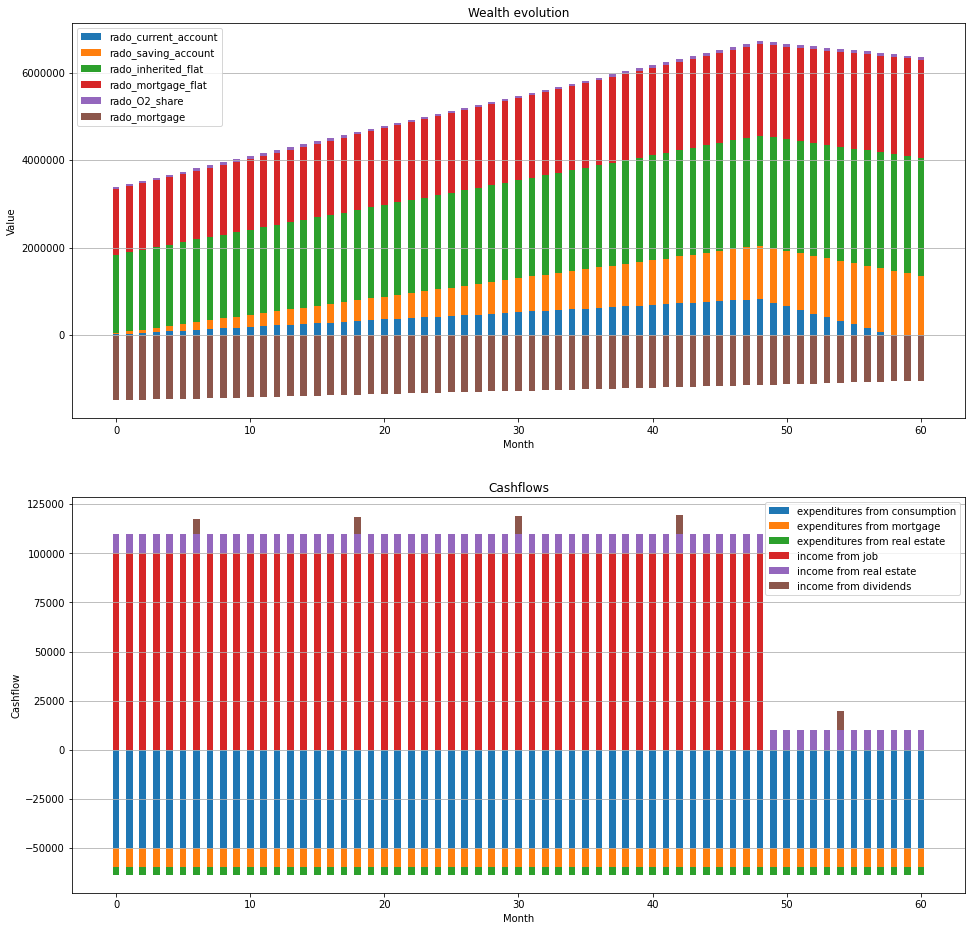

In [11]:
plt.plot_wealth_evolution()

In [12]:
# # Income
# employee_contract = EmployeeContract(id='rado_credo', salary = 100000, income_tax_rate = 0.0, logger=logger, events=employee_contract_events, n_years=4)

# # SA & CA
# current_account = CurrentAccount(id='rado_current_account', current_outstanding=0.0, monthly_cost= 0.0, cnit=0.0, logger=logger, primary=True)
# saving_account = CurrentAccount(id='rado_saving_account', current_outstanding=0.0, monthly_cost= 0.0, cnit=0.001, logger=logger)

# # Shares


# # Real Estate
# inherited_flat = RealEstate(id='rado_inherited_flat', current_market_value=1.8e6, property_tax = 2000, house_community_costs = 5000, real_estate_index = re_index, logger=logger, events=None) 
# # mortgage = Mortgage(id='rado_mortgage', principal=3e6, cnit=0.02, maturity_in_years=30, logger=logger)
# # mortgage_flat = RealEstate(id='rado_mortgage_flat', current_market_value=5e6, property_tax = 2000, house_community_costs = 6000, real_estate_index = re_index, logger=logger, events=mortgage_flat_events)

# # Rental agreement
# rent_from_inherited_flat = RentalAgreement(id='rado_rent_from_inherited_flat', logger=logger, inflation_index=inflation_index, my_position='renter', rent=10000, yearly_costs=0)

In [13]:
# div_step = 3

# for i in range(0,26):
#     f = (i//12)*12+div_step
#     print('{} | {} | {} | {}'.format(i, div_step, f,i==f))